<a href="https://colab.research.google.com/github/valdolab/DS_mAIstros/blob/main/Assignment2_Bayesian_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 2
### Bayesian Inference and the MNIST Dataset

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
#import the lbs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from tqdm import tqdm

from scipy.stats import multivariate_normal as mvn

In [21]:
#load dataset and view
data = pd.read_csv('/content/drive/MyDrive/Classroom/DS mAIstros/datasets/MNIST_train.csv')
data

,Unnamed: 0,index,labels,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,59995,59995,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,59996,59996,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,59997,59997,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,59998,59998,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
data.shape

(60000, 787)

In [23]:
#drop the first 2 columns
data.drop(data.columns[[0,1]], axis=1, inplace=True)
data

,labels,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#convert to numpy array to save memory, because
x = data.to_numpy()
x

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0],
       [8, 0, 0, ..., 0, 0, 0]])

In [25]:
#target is the first one
set(x[:,0])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [26]:
y = x[:,0]
y.shape

(60000,)

In [27]:
x=x[:,1:]
x.shape

(60000, 784)

### Classifiers
#### GaussNB Classifier

In [ ]:
#gaussNB classifier and accuracy function
class GaussNB():
    def fit(self, X, y, epsilon = 1e-3):
        
        self.likelihoods = dict()
        self.priors = dict()
        
        self.K = set(y.astype(int))
        for k in tqdm(self.K):
            X_k = X[y==k,:]
            N_k, D = X_k.shape
            mu_k = X_k.mean(axis=0)
            self.likelihoods[k] = {"mean": mu_k, "cov": (1/(N_k-1))*np.matmul((X_k-mu_k).T, X_k-mu_k) + epsilon*np.identity(D)}
            self.priors[k] = len(X_k)/len(X)
            
    def predict(self, X):
        N, D = X.shape
        P_hat = np.zeros((N, len(self.K)))
        for k, l in tqdm(self.likelihoods.items()):
            #bayes theorem computation
            P_hat[:,k] = mvn.logpdf(X, l["mean"], l["cov"]) + np.log(self.priors[k])
        
        return P_hat.argmax(axis=1)

#### kNN Classifier

In [ ]:
class KNNclassifier():
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, X, K, epsilon=1e-3):
        N = len(X)
        y_hat = np.zeros(N)
        for i in tqdm(range(N)):
            dist2 = np.sum((self.X-X[i])**2, axis=1)
            idxt = np.argsort(dist2)[:K]
            gamme_k = 1/(np.sqrt(dist2[idxt]+epsilon))
            y_hat[i] = np.bincount(self.y[idxt], weights=gamme_k).argmax()
        
        return y_hat

In [ ]:
#accuracy function
def accuracy(y, y_hat):
    return np.mean(y==y_hat)

In [ ]:
#using the GaussNB to make the predictions
gnb = GaussNB()
gnb.fit(x, y)

100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


In [ ]:
#this is using the same training dataset to test
y_hat = gnb.predict(x)
#get accuracy
accuracy(y, y_hat)

100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


0.78565

In [ ]:
#using the kNN to make the predictions
knn_model = KNNclassifier()
knn_model.fit(x, y)

In [ ]:
#with k=1 and using the same data to train and test always is 1 of accuracy because the nearest point is the point itself
#this is using the same training dataset to test
k = 5
y_hat = knn_model.predict(x, k)
#get accuracy
accuracy(y, y_hat)

### Predictions using the test dataset

In [ ]:
#load the test data
data_test = pd.read_csv('/content/drive/MyDrive/Classroom/DS mAIstros/datasets/MNIST_test.csv')
data_test

,Unnamed: 0,index,labels,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,0,0,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,9995,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,9996,9996,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,9997,9997,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,9998,9998,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#drop the first 2 columns
data_test.drop(data_test.columns[[0,1]], axis=1, inplace=True)
data_test

,labels,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
x_test = data_test.to_numpy()

In [ ]:
set(x_test[:,0])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [ ]:
y_test = x_test[:,0]
x_test = x_test[:,1:]

### Predictions using test dataset
#### GaussNB Classifier

In [ ]:
#using the GaussNB to make the predictions
gnb = GaussNB()
gnb.fit(x, y)
y_hat_test = gnb.predict(x_test)
#get accuracy
accuracy(y_hat_test, y_test)

100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


0.7532

#### kNN Classifier

In [ ]:
#using the GaussNB to make the predictions
knn_model = KNNclassifier()
knn_model.fit(x, y)
k = 5
y_hat_test = knn_model.predict(x_test, k)
#get accuracy
accuracy(y_hat_test, y_test)

100%|██████████| 10000/10000 [53:22<00:00,  3.12it/s] 


0.9691

### Plot each number of the dataset

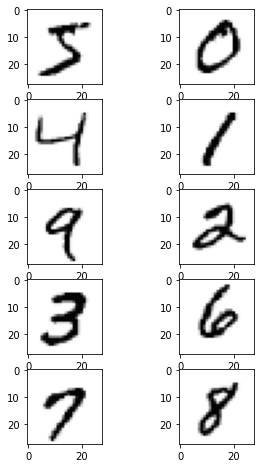

In [55]:
#find all the examples of the dataset
indexs = []
numbers = []
for i in range(len(y)):
  if y[i] not in numbers:
    numbers.append(y[i])
    indexs.append(i)

x_plot = x.reshape(-1, 28, 28)

#print each number in a same plot
fig = plt.figure(figsize=(5, 8))
for i in range(len(indexs)):
  fig.add_subplot(5, 2, i+1)
  plt.imshow(x_plot[indexs[i]], cmap='Greys')

plt.show()